#### Projekt PPA2

Zadáním projektu je vymyslet nějakou strategii automatického nákupu a prodeje virtuální měny.  
Program má 4 části:  
1. Načtení dat z burzy  
2. Výpočet trendů popisujících vývoj ceny  
3. Uplatnění kritéria pro nákup a prodej  
4. Vykreslení grafu  
  
**Načtení dat z burzy**  
Data načítám dynamicky ze webu cryptocompare.com  
  
**Výpočet trendů popisujících vývoj ceny**  
K výpočtům používám knihovnu pandas, která se často používá na analýzu dat a výrazně ulehčuje programátorovi práci.  
V analýze se snažím zjistit především 2 věci:  
  a) zda je aktuální cena vysoká nebo nízká  
  b) zda aktuální cenový trend stoupá či klesá  
Opírám se hlavně o funkce vážený průměr a exponenciální vážený průměr v určité periodě.  
  
**Uplatnění kritéria pro nákup a prodej**   
Kritérium pro nákup volím tak, že cena musí být nízká tedy podprůměrná (pod linkou "buy_line") a zároveň cenový trend musí být rostoucí. Kritérium pro prodej volím tak, že cena musí být vysoká tedy nadprůměrná (nad linkou "ema100") a trend musí být již klesající. Dále jsem přidal pojistku pro špatný nákup tj. pokud dojde ke nákupu a cena klesne o 10% prodávám se ztrátou. Program vypíše jednotlivé obchody a spočítá ztrátu či zisk.  
  
**Vykreslení grafu**  
Program vykreslí graf a barevně odliší trendy a vyznačí místa uskutečněných obchodů.   
  
#### Ovládání
Program pracuje s částkou 5000 USD.  
Lze navolit libovolnou cryptoměnu, která je na webu cryptocompare.com podporovaná.  
Dále lze navolit i datum, odkdy se mají data zpracovávat a počet dat zpětně.  
  
#### Závěr 
Je třeba dodat, že obchody jsou v reálu zpoplatněny cca 0.25% z ceny obchodu.   
I tak se ale zdá, že obchodování je ziskové :) Pravděpodobně kvůli vysoké volatilitě.  
  

In [3]:
import json
import requests
import decimal
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from datetime import datetime, timedelta
import matplotlib.dates as mdates

global money  # usd
global bitcoin
global bitcoin_buy_price

def read_data(dt_from, count=2000, from_symbol='BTC', to_symbol='USD', exchange='Poloniex'):
    """ Load dataset from internet """
    ts_now = dt_from.timestamp()
    qs = 'fsym={}&tsym={}&toTs={}&e={}&limit={}'.format(from_symbol, to_symbol,
                                                        int(ts_now), exchange, count)
    if count <= 2000:
        url = 'https://min-api.cryptocompare.com/data/histohour?' + qs
    else:
        url = 'https://min-api.cryptocompare.com/data/histominute?' + qs
    response = requests.get(url)
    data = json.loads(response.content)['Data']
    df = pd.DataFrame(data)
    df.index = df.time.map(lambda x: datetime.fromtimestamp(int(x)))
    df['balance'] = json.dumps({'usd': 0.0, 'btc': 0.0})
    plt.show()
    return df


In [4]:
def get_presignal(row):
    """ 
    Detects if there is a change in trend 
    For a change we need 2 same sequent signals
    """
    if row.color > 1 and row.color_shift > 1 and row.color_shift2 < 1 and row.color_shift3 < 1:
        # 2 : 2 : 0|-2, : 0|-2
        return 1    # turn up
    if row.color < -1 and row.color_shift < -1 and row.color_shift2 > -1 and row.color_shift3 > -1:
        # -2 : -2 : 0|2 : 0|2
        return -1  # turn down
    return 0


In [5]:
def get_balance(row):
    """ Executes a trade upon signal """
    global money
    global bitcoin
    if row.signal == 1:
        bitcoin = money / row.close
        money = 0
    if row.signal == -1:
        money = bitcoin * row.close
        bitcoin = 0
    return json.dumps({'usd': money, 'btc': bitcoin})


In [6]:
def get_signal(row):
    """ Processes pre-signals and raise signals """
    global money
    global bitcoin
    global bitcoin_buy_price

    # BUY
    if money > 0: # have money
        if row.close < row.buy_line:
            # if price is low under EMA100

            if row.pre_signal == 1:
                # trend is UP (pre_signal == 1)
                bitcoin = money / row.close
                bitcoin_buy_price = row.close
                money = 0
                print('{:%Y-%m-%d %H:%M}  ===  {:+d}   ---   {:8.3f}   ---  {:8.3f}   BUY:({:8.3f})'.format(datetime.fromtimestamp(row.time),
                                                                  row.pre_signal, money, bitcoin, row.close))
                return 1

    # SELL
    if bitcoin > 0:
        if row.close > row.ema100:
            # high price
            if row.pre_signal == -1:
                # trend is DOWN (pre_signal == -1)
                money = bitcoin * row.close
                bitcoin = 0
                print('{:%Y-%m-%d %H:%M}  ===  {:+d}   ---   {:8.3f}   ---  {:8.3f}   SELL({:8.3f})'.format(datetime.fromtimestamp(row.time),
                                                                  row.pre_signal, money, bitcoin, row.close))
                return -1
        else:
            # low price
            if row.close < bitcoin_buy_price * 0.90:
                # more then 10% loss - wrong buy
                money = bitcoin * row.close
                bitcoin = 0
                print(
                    '{:%Y-%m-%d %H:%M}  ===  {:+d}   ---   {:8.3f}   ---  {:8.3f}   SELL({:8.3f})'.format(
                        datetime.fromtimestamp(row.time),
                        row.pre_signal, money, bitcoin, row.close))
                return -1
    return 0

In [7]:

def calculate_signal(df):
    """ 
    Calculating all helper data columns
    Mostly based on exponential weighted mean and other rolling functions
    EMA and difference 
    """ 
    period = 100

    df['close_shift'] = df['close'].shift()
    df['close_shift2'] = df['close'].shift(2)

    df['ema100'] = df['close'].ewm(period).mean()
    df['average'] = df['ema100'].mean()
    df['ema5'] = df['close'].ewm(5).mean()
    df['ema_buy'] = df['close'].rolling(window=50, center=True, min_periods=2).mean() * 0.98
    df['add'] = (df['ema5'] - df['average']) * 0.18
    df['buy_line'] = (df['ema100'] + df['ema_buy'])/2 + df['add'].abs()
    df['mean20'] = df['close'].rolling(window=25, center=True, min_periods=2).mean()
    df['mean20_shift'] = df['mean20'].shift()

    df['diff2'] = (df['mean20'].diff(periods=1) + df['mean20']/100000)      # this is tolerance when derivation is near zero
    df['diff'] = df['diff2'].rolling(window=10, center=True, min_periods=1).mean()

    df['color'] = np.where(df['diff'] < 0, -2, np.where(df['diff'] > 0, 2, 0))
    df['color_shift'] = np.where(df['diff'].shift() < 0, -2, np.where(df['diff'].shift() > 0, 2, 0))
    df['color_shift2'] = np.where(df['diff'].shift(2) < 0, -2, np.where(df['diff'].shift(2) > 0, 2, 0))
    df['color_shift3'] = np.where(df['diff'].shift(3) < 0, -2, np.where(df['diff'].shift(3) > 0, 2, 0))
    df['pre_signal'] = df.apply(get_presignal, axis=1)
    
    print('Starts with:')
    print('Money = 5000 USD')
    print('Coins = 0 BTC')
    print('DateTime          ===  S    ---        USD   ---      Coin    Price in USD')
    df['signal'] = df.apply(get_signal, axis=1)
    df['balance'] = df.apply(get_balance, axis=1)
    return df

In [8]:

def draw_graph(df, from_symbol='BTC', to_symbol='USD'):
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    ax.plot(df.index, df['close'], alpha=0.0)

    # convert dates to numbers first
    inxval = mdates.date2num(df.index.to_pydatetime())
    points = np.array([inxval, df['close']]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # colorize line
    cmap = ListedColormap(['r', 'b', 'g'])
    norm = BoundaryNorm([-2, -1, 1, 2], cmap.N)
    lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=1)
    lc.set_array(market_data['color'])
    ax.add_collection(lc)

    # SELL Signal
    below_threshold = df[df['signal'] == -1]
    plt.scatter(below_threshold.index, below_threshold['close'], color='red')

    # BUY Signal
    below_threshold = df[df['signal'] == 1]
    plt.scatter(below_threshold.index, below_threshold['close'], color='darkgreen')

    # helper lines
    # plt.plot(market_data.index, market_data['average'], color='gray')
    # plt.plot(df.index, df['ema100'], color='pink')
    # plt.plot(df.index, df['buy_line'], color='orange')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    monthFmt = mdates.DateFormatter("%b")
    ax.xaxis.set_major_formatter(monthFmt)

    plt.title('{}/{}'.format(from_symbol, to_symbol))
    plt.grid(True)

    xfmt = mdates.DateFormatter('%m-%d %H')
    ax.xaxis.set_major_formatter(xfmt)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

    h = df['close'].max() - df['close'].min()
    y_min = df['close'].min() - h / 2
    y_max = df['close'].max() + h / 2
    plt.axis([df.index.min() + timedelta(hours=12), df.index.max(), y_min, y_max])
    plt.setp(plt.gca().xaxis.get_majorticklabels(), 'rotation', 90)
    plt.show()

Starts with:
Money = 5000 USD
Coins = 0 BTC
DateTime          ===  S    ---        USD   ---      Coin    Price in USD
2017-05-31 10:00  ===  +1   ---      0.000   ---     2.372   BUY:(2108.000)
2017-06-02 00:00  ===  -1   ---   5437.856   ---     0.000   SELL(2292.600)
2017-06-02 06:00  ===  +1   ---      0.000   ---     2.341   BUY:(2322.680)
2017-06-03 22:00  ===  -1   ---   5759.349   ---     0.000   SELL(2460.000)
2017-06-04 22:00  ===  +1   ---      0.000   ---     2.412   BUY:(2387.440)
2017-06-07 01:00  ===  -1   ---   6865.558   ---     0.000   SELL(2846.000)
2017-06-13 05:00  ===  +1   ---      0.000   ---     2.707   BUY:(2535.840)
2017-06-15 07:00  ===  +0   ---   6018.085   ---     0.000   SELL(2222.820)
2017-06-15 20:00  ===  +1   ---      0.000   ---     2.690   BUY:(2237.000)
2017-06-18 05:00  ===  -1   ---   7072.124   ---     0.000   SELL(2628.800)
2017-06-19 03:00  ===  +1   ---      0.000   ---     2.840   BUY:(2490.370)
2017-06-21 08:00  ===  -1   ---   7613.416   

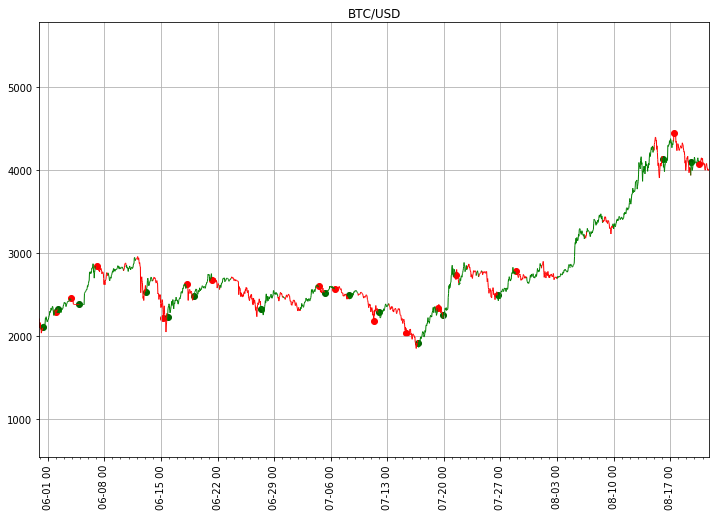

In [9]:
money = 5000  # start money 5000USD
bitcoin = 0
bitcoin_buy_price = 0
from_symbol = 'BTC'    # ['BTC', 'ETH', 'DASH', 'XMR', 'XRP', 'LTC', 'ETC', 'XEM', 'REP']

#dt_from = datetime.strptime('2017-07-22 06:00', "%Y-%m-%d %H:%M")
dt_from = datetime.utcnow()
market_data = read_data(dt_from, 2000, from_symbol=from_symbol)
market_data = calculate_signal(market_data)
draw_graph(market_data)